In [17]:
import numpy as np
import pandas as pd

import time
import gym

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tqdm import tqdm
import random

import torch.nn.functional as F
import torch 
from torch import nn
import torch.optim as optim
import torchvision.transforms as T
from PIL import Image
from collections import deque

import time

In [18]:
from mario2 import MyMarioEnvironment2

In [19]:
class DQN_FC(nn.Module):
    def __init__(self, i, o):
        super(DQN_FC, self).__init__()
        self.fc1 = nn.Linear(in_features=i, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=64)
        
        self.value = nn.Linear(in_features=64, out_features=1)

        self.advantage = nn.Linear(in_features=64, out_features=o)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        val = self.relu(self.fc2(x))
        val = self.value(val)

        adv = self.relu(self.fc2(x))
        adv = self.advantage(adv)
        q_val = val + adv - adv.mean(dim=1, keepdim=True)
        return q_val.float()  

In [26]:
class DQN_CNN(nn.Module):
    def __init__(self, h, w, o):
        super(DQN_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32, kernel_size=4, stride=2)
        # print(self.conv_output_shape(h,8,4,0,1))
        out_conv_h = self.conv_output_shape(self.conv_output_shape(h,8,4,0,1),4,2,0,1)
        out_conv_w = self.conv_output_shape(self.conv_output_shape(w,8,4,0,1),4,2,0,1)
        self.fc = nn.Linear(in_features=out_conv_h*out_conv_w*32, out_features=o)
        # print(h,w, out_conv_h,out_conv_w)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.relu(self.conv1(x))
        # print("c1",x.shape)
        x = self.relu(self.conv2(x))
        # print("c2",x.shape)
        x = self.sigmoid(self.fc(self.flatten(x)))
        return x
    
    def conv_output_shape(self, size, kernel_size=1, stride=1, pad=0, dilation=1):
        from math import floor
        if type(kernel_size) is not tuple:
            kernel_size = (kernel_size, kernel_size)
        out = floor( ((size + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )// stride) + 1)
        return out

In [20]:
class GridDuelingDQN():
    def __init__(self, env, typ="dense", gamma=0.90):
      self.env = env
      self.typ = typ
      self.max_episodes = 2500
      self.max_steps = 30
      self.gamma = gamma
      self.epsilon = 1.0
      self.epsilon_min = 0.01
      self.epsilon_decay_lamda = self.epsilon_min**(1/self.max_episodes)
      self.target_update_counter = 0
      self.target_update_frequency = 10
      self.buffer_minibatch_size = 50
      self.replay_buffer_capacity=2500
      self.replay_buffer = deque([],maxlen=self.replay_buffer_capacity)
      self.resize = T.Compose([T.ToPILImage(),
                    T.Resize(84, interpolation=Image.CUBIC),
                    T.Grayscale(),
                    T.ToTensor()])  
      env.reset()
#       _, _, self.state_screen_h, self.state_screen_w = self.screen_preprocessor(self.env.render()).shape
      obs,aud = self.env.reset()
      obs.extend(self.env.reset()[1])
      lenn = len(obs)
      self.state_count = env.observation_space.n
      self.action_count = env.action_space.n
      self.target_dqn = DQN_FC(lenn, self.action_count) 
      self.q_value_dqn = DQN_FC(lenn, self.action_count)
      # self.rms_optimizer = optim.RMSprop(self.q_value_dqn.parameters())#, lr=0.001)#, weight_decay=0.05)
      # self.loss_func = F.smooth_l1_loss
      self.rms_optimizer = optim.SGD(self.q_value_dqn.parameters(), lr=0.005)#optim.RMSprop(self.q_value_dqn.parameters(), lr=0.001)#, weight_decay=0.05)
      self.loss_func = F.mse_loss #F.smooth_l1_loss
      
      self.timestep_list = []
      self.rewards_list = []
      self.epsilon_list = []
      
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      self.q_value_dqn#.to(self.device)
      self.target_dqn#.to(self.device)

      self.test_max_episodes = 10
      self.test_timestep_list = []
      self.test_rewards_list = []
      self.test_epsilon_list = []
      self.trained_policy_path = "./grid.pth"

    
    def choose_action(self, state, test=False):
      random_no = np.random.random()
      if self.epsilon > random_no and not test:
          return np.random.choice(self.env.action_space.n)
      else:
          return torch.argmax(self.q_value_dqn(state)).item()#.to(self.device))
    
    def get_q_value_for_state(self, state):
      q_values = self.q_value_dqn(state)
      return q_values.max(1)[1].view(1, 1)

    def eval(self,load=False, max_ep=10):
      if load:
        self.q_value_dqn.load_state_dict(torch.load(self.trained_policy_path))
      
      self.test_max_episodes = max_ep
      for episode in tqdm(range(0, self.test_max_episodes), unit='episodes'):
        obs, aud = self.env.reset()
        obs.extend(aud)
        obs = torch.tensor(obs,dtype=torch.float)
        done = False
        reward_sum = 0
        steps = 0
        current_state = obs.unsqueeze(0)
        while not done:
          tt = time.time()

          current_action = self.choose_action(current_state, test=True)#.to(self.device)
          curr_obs, curr_aud, curr_reward, done, info = self.env.step(self.env.actions[current_action][0])
          curr_obs.extend(curr_aud)
          curr_obs = torch.tensor(curr_obs,dtype=torch.float)
          
          # self.env.render(mode="human", save=True, step=steps)
          reward_sum += curr_reward
          next_state = curr_obs.unsqueeze(0)

          steps +=1
          
          current_state = next_state
          if steps==20 or reward_sum==16:
            done=True
            
        self.test_timestep_list.append(steps)
        self.test_rewards_list.append(reward_sum)


    def train(self):
      current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch = self.get_minibatch_from_replay_buffer()
      # with torch.no_grad():
      curr_q_value_list = self.q_value_dqn(current_state_batch).gather(1, current_action_batch.reshape([self.buffer_minibatch_size,1]))
      best_actions = torch.argmax(self.q_value_dqn(next_state_batch), dim=1)
      next_q_value_list = self.target_dqn(next_state_batch)

      next_q_value_list = next_q_value_list.gather(1, best_actions.reshape([self.buffer_minibatch_size, 1]))
      next_q_value_list = next_q_value_list.detach()
      exp_q_value_list = []
      for index in range(self.buffer_minibatch_size):
        if current_done_batch[index]:
          exp_q_value_list.append(current_reward_batch[index])
        else:
          exp_q_value_list.append((current_reward_batch[index] + next_q_value_list[index] * self.gamma))

      exp_q_value_list = torch.tensor(exp_q_value_list).unsqueeze(1)#.to(self.device)

      self.rms_optimizer.zero_grad()
      loss = self.loss_func(curr_q_value_list, exp_q_value_list)
      loss.backward()
      for param in self.q_value_dqn.parameters():
          param.grad.data.clamp_(-1, 1)
      self.rms_optimizer.step()

      return 0#loss.item()
      
    def learn(self):
      self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
      self.target_dqn.eval()
      
      running_loss=0
      loss=0
      self.tm = []
      self.tr = []
      for episode in tqdm(range(0, self.max_episodes), unit='episodes'):
        # with Profiler() as p:
        obs, aud_obs = self.env.reset()
        obs.extend(aud_obs)
        obs = torch.tensor(obs,dtype=torch.float)
        done = False
        reward_sum = 0
        steps = 0
        current_state = obs.unsqueeze(0) if self.typ=="dense" else self.screen_preprocessor(self.env.render())
        while not done:
            tt = time.time()

            current_action = self.choose_action(current_state)#.to(self.device)
            curr_obs, curr_audio, curr_reward, done, info = self.env.step(self.env.actions[current_action][0])
            curr_obs.extend(curr_audio)
            curr_obs = torch.tensor(curr_obs, dtype=torch.float)
#             print(current_state, current_action, curr_obs, curr_reward, done)

            reward_sum += curr_reward

            next_state = curr_obs.unsqueeze(0) 

            self.add_to_replay_buffer((current_state, current_action, curr_reward, next_state, done))
            t = time.time() 

            if len(self.replay_buffer) >= self.buffer_minibatch_size:       
                loss = self.train()
            self.tm.append(time.time()-t)
            steps +=1
            running_loss = loss*self.buffer_minibatch_size
            current_state = next_state

            self.tr.append(time.time()-tt)
            if steps==self.max_steps or reward_sum==16:
                done=True

        self.update_target_net(episode)
            
        self.timestep_list.append(steps)
        self.rewards_list.append(reward_sum)
        self.epsilon_list.append(self.epsilon)
        self.epsilon = max(0.01, self.epsilon*self.epsilon_decay_lamda) #if episode>500 else self.epsilon
      
        if episode % 100 == 99:
          print(f"Buffer_size: {len(self.replay_buffer)}|Train_time:{sum(self.tm[-100:])/100}| Sub_t:{sum(self.tr[-100:])/100}")
          # print(f'[Episode: {episode+1}] - Steps: {steps+1} | Rewards: {reward_sum+1} | Epsilon: {self.epsilon} | loss: {running_loss / 10:.3f}')
          print(f'[Episode: {episode+1}] - Steps: {sum(self.timestep_list[-100:])/100} | Rewards: {sum(self.rewards_list[-100:])/100} | Epsilon: {self.epsilon} | loss: {running_loss / 10:.3f}')
          running_loss = 0.0
          # p.print()
        
    def update_target_net(self, episode):
       if episode % self.target_update_frequency == self.target_update_frequency-1:   
          self.target_dqn.load_state_dict(self.q_value_dqn.state_dict())
          # q_value_dict = self.q_value_dqn.state_dict()
          # target_dict = self.target_dqn.state_dict()
        
              
    
    def get_minibatch_from_replay_buffer(self):
      exp_batch = random.sample(self.replay_buffer, self.buffer_minibatch_size) #max(len(self.replay_buffer), self.buffer_minibatch_size))
      current_state_batch = torch.cat(tuple([exp[0] for exp in exp_batch]),dim=0,)
#       current_action_batch = torch.cat(tuple([exp[1] for exp in exp_batch]),dim=0)
      current_action_batch = torch.as_tensor([exp[1] for exp in exp_batch])
      next_state_batch = torch.cat(tuple([exp[3] for exp in exp_batch]),dim=0)
      current_reward_batch = torch.FloatTensor(tuple([exp[2] for exp in exp_batch]))#.to(self.device)
      current_done_batch = torch.FloatTensor(tuple([exp[4] for exp in exp_batch]))#.to(self.device)
      return current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch
    
    def add_to_replay_buffer(self, experience):
       self.replay_buffer.append(experience)

In [21]:
env = MyMarioEnvironment2(environment_type = 'deterministic')

a = GridDuelingDQN(env, gamma=0.999)
a.learn()
rewardSD_g1 = a.rewards_list

env = MyMarioEnvironment2(environment_type = 'deterministic')
a = GridDuelingDQN(env, gamma=0.990)
a.learn()
rewardSD_g2 = a.rewards_list

env = MyMarioEnvironment2(environment_type = 'deterministic')
a = GridDuelingDQN(env, gamma=0.90)
a.learn()
rewardSD_g3 = a.rewards_list

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
  4%|▍         | 101/2500 [00:17<06:24,  6.24episodes/s]

Buffer_size: 2500|Train_time:0.0043507075309753415| Sub_t:0.004786384105682373
[Episode: 100] - Steps: 29.21 | Rewards: -4.92 | Epsilon: 0.8317637711026726 | loss: 0.000


  8%|▊         | 200/2500 [00:34<06:47,  5.65episodes/s]

Buffer_size: 2500|Train_time:0.005575935840606689| Sub_t:0.006234166622161866
[Episode: 200] - Steps: 27.19 | Rewards: -1.05 | Epsilon: 0.691830970918939 | loss: 0.000


 12%|█▏        | 301/2500 [00:50<04:48,  7.62episodes/s]

Buffer_size: 2500|Train_time:0.004123198986053467| Sub_t:0.004578337669372558
[Episode: 300] - Steps: 26.26 | Rewards: 2.17 | Epsilon: 0.5754399373371608 | loss: 0.000


 16%|█▌        | 401/2500 [01:04<04:06,  8.53episodes/s]

Buffer_size: 2500|Train_time:0.004062814712524414| Sub_t:0.004575662612915039
[Episode: 400] - Steps: 24.6 | Rewards: 3.83 | Epsilon: 0.47863009232264275 | loss: 0.000


 20%|██        | 500/2500 [01:21<05:02,  6.60episodes/s]

Buffer_size: 2500|Train_time:0.004260618686676026| Sub_t:0.004870433807373047
[Episode: 500] - Steps: 29.4 | Rewards: -4.6 | Epsilon: 0.3981071705535017 | loss: 0.000


 24%|██▍       | 601/2500 [01:38<06:05,  5.20episodes/s]

Buffer_size: 2500|Train_time:0.005298616886138916| Sub_t:0.006042318344116211
[Episode: 600] - Steps: 29.56 | Rewards: -2.03 | Epsilon: 0.3311311214825956 | loss: 0.000


 28%|██▊       | 701/2500 [01:55<05:08,  5.84episodes/s]

Buffer_size: 2500|Train_time:0.00494359016418457| Sub_t:0.005589237213134765
[Episode: 700] - Steps: 29.98 | Rewards: -3.97 | Epsilon: 0.27542287033382085 | loss: 0.000


 32%|███▏      | 801/2500 [02:16<07:40,  3.69episodes/s]

Buffer_size: 2500|Train_time:0.00840829849243164| Sub_t:0.009277923107147217
[Episode: 800] - Steps: 30.0 | Rewards: -1.41 | Epsilon: 0.22908676527678132 | loss: 0.000


 36%|███▌      | 901/2500 [02:33<04:06,  6.48episodes/s]

Buffer_size: 2500|Train_time:0.004321670532226563| Sub_t:0.0049716043472290035
[Episode: 900] - Steps: 30.0 | Rewards: -2.24 | Epsilon: 0.19054607179632832 | loss: 0.000


 40%|████      | 1001/2500 [02:51<04:41,  5.33episodes/s]

Buffer_size: 2500|Train_time:0.004514505863189697| Sub_t:0.005247595310211181
[Episode: 1000] - Steps: 29.95 | Rewards: -1.63 | Epsilon: 0.15848931924611465 | loss: 0.000


 44%|████▍     | 1100/2500 [03:09<04:04,  5.74episodes/s]

Buffer_size: 2500|Train_time:0.004809298515319824| Sub_t:0.0056229734420776365
[Episode: 1100] - Steps: 30.0 | Rewards: -1.5 | Epsilon: 0.13182567385564378 | loss: 0.000


 48%|████▊     | 1201/2500 [03:27<04:14,  5.10episodes/s]

Buffer_size: 2500|Train_time:0.008459739685058594| Sub_t:0.009118726253509521
[Episode: 1200] - Steps: 30.0 | Rewards: -1.29 | Epsilon: 0.10964781961432139 | loss: 0.000


 52%|█████▏    | 1301/2500 [03:44<02:59,  6.67episodes/s]

Buffer_size: 2500|Train_time:0.004117546081542969| Sub_t:0.004745204448699952
[Episode: 1300] - Steps: 30.0 | Rewards: -1.47 | Epsilon: 0.09120108393559365 | loss: 0.000


 56%|█████▌    | 1401/2500 [04:02<02:56,  6.24episodes/s]

Buffer_size: 2500|Train_time:0.004417192935943603| Sub_t:0.005118496417999267
[Episode: 1400] - Steps: 30.0 | Rewards: -0.47 | Epsilon: 0.07585775750292077 | loss: 0.000


 60%|██████    | 1501/2500 [04:20<02:36,  6.37episodes/s]

Buffer_size: 2500|Train_time:0.004176132678985596| Sub_t:0.005033452510833741
[Episode: 1500] - Steps: 30.0 | Rewards: -0.79 | Epsilon: 0.06309573444802141 | loss: 0.000


 64%|██████▍   | 1601/2500 [04:39<02:15,  6.63episodes/s]

Buffer_size: 2500|Train_time:0.003955206871032715| Sub_t:0.004706263542175293
[Episode: 1600] - Steps: 30.0 | Rewards: -0.94 | Epsilon: 0.052480746024979104 | loss: 0.000


 68%|██████▊   | 1701/2500 [04:56<02:09,  6.19episodes/s]

Buffer_size: 2500|Train_time:0.0042585086822509765| Sub_t:0.00500995397567749
[Episode: 1700] - Steps: 30.0 | Rewards: -0.08 | Epsilon: 0.043651583224018214 | loss: 0.000


 72%|███████▏  | 1801/2500 [05:14<01:48,  6.46episodes/s]

Buffer_size: 2500|Train_time:0.0042707276344299315| Sub_t:0.004970829486846923
[Episode: 1800] - Steps: 30.0 | Rewards: -0.31 | Epsilon: 0.03630780547701154 | loss: 0.000


 76%|███████▌  | 1901/2500 [05:32<01:45,  5.68episodes/s]

Buffer_size: 2500|Train_time:0.005204029083251953| Sub_t:0.005936996936798096
[Episode: 1900] - Steps: 30.0 | Rewards: -0.31 | Epsilon: 0.030199517204021385 | loss: 0.000


 80%|████████  | 2001/2500 [05:49<01:22,  6.02episodes/s]

Buffer_size: 2500|Train_time:0.004370532035827637| Sub_t:0.00508434534072876
[Episode: 2000] - Steps: 29.97 | Rewards: -0.27 | Epsilon: 0.025118864315096866 | loss: 0.000


 84%|████████▍ | 2101/2500 [06:10<01:41,  3.93episodes/s]

Buffer_size: 2500|Train_time:0.008865935802459717| Sub_t:0.009705173969268798
[Episode: 2100] - Steps: 30.0 | Rewards: -0.34 | Epsilon: 0.02089296130854132 | loss: 0.000


 88%|████████▊ | 2200/2500 [06:28<00:53,  5.62episodes/s]

Buffer_size: 2500|Train_time:0.005313715934753418| Sub_t:0.006131248474121094
[Episode: 2200] - Steps: 30.0 | Rewards: -0.8 | Epsilon: 0.017378008287494567 | loss: 0.000


 92%|█████████▏| 2300/2500 [06:46<00:31,  6.31episodes/s]

Buffer_size: 2500|Train_time:0.004354174137115478| Sub_t:0.005107605457305908
[Episode: 2300] - Steps: 30.0 | Rewards: -1.65 | Epsilon: 0.014454397707459973 | loss: 0.000


 96%|█████████▌| 2401/2500 [07:04<00:15,  6.52episodes/s]

Buffer_size: 2500|Train_time:0.004427950382232666| Sub_t:0.005157899856567383
[Episode: 2400] - Steps: 30.0 | Rewards: -0.04 | Epsilon: 0.012022644346174735 | loss: 0.000


100%|██████████| 2500/2500 [07:24<00:00,  5.62episodes/s]


Buffer_size: 2500|Train_time:0.004264369010925293| Sub_t:0.004986107349395752
[Episode: 2500] - Steps: 30.0 | Rewards: -0.4 | Epsilon: 0.01000000000000053 | loss: 0.000


  4%|▍         | 101/2500 [00:17<05:57,  6.71episodes/s]

Buffer_size: 2500|Train_time:0.004206423759460449| Sub_t:0.004607810974121094
[Episode: 100] - Steps: 29.98 | Rewards: -5.98 | Epsilon: 0.8317637711026726 | loss: 0.000


  8%|▊         | 201/2500 [00:33<04:58,  7.69episodes/s]

Buffer_size: 2500|Train_time:0.0043030595779418946| Sub_t:0.004875891208648682
[Episode: 200] - Steps: 29.54 | Rewards: -4.47 | Epsilon: 0.691830970918939 | loss: 0.000


 12%|█▏        | 301/2500 [00:48<05:07,  7.14episodes/s]

Buffer_size: 2500|Train_time:0.004203641414642334| Sub_t:0.004885766506195068
[Episode: 300] - Steps: 25.54 | Rewards: 3.84 | Epsilon: 0.5754399373371608 | loss: 0.000


 16%|█▌        | 401/2500 [01:03<04:33,  7.66episodes/s]

Buffer_size: 2500|Train_time:0.004113471508026123| Sub_t:0.004652047157287597
[Episode: 400] - Steps: 24.06 | Rewards: 5.45 | Epsilon: 0.47863009232264275 | loss: 0.000


 20%|██        | 500/2500 [01:19<05:06,  6.53episodes/s]

Buffer_size: 2500|Train_time:0.004309985637664795| Sub_t:0.004920506477355957
[Episode: 500] - Steps: 26.69 | Rewards: 0.53 | Epsilon: 0.3981071705535017 | loss: 0.000


 24%|██▍       | 601/2500 [01:37<05:43,  5.53episodes/s]

Buffer_size: 2500|Train_time:0.0051684904098510745| Sub_t:0.005950608253479004
[Episode: 600] - Steps: 30.0 | Rewards: -5.27 | Epsilon: 0.3311311214825956 | loss: 0.000


 28%|██▊       | 700/2500 [01:55<05:00,  5.98episodes/s]

Buffer_size: 2500|Train_time:0.004520299434661865| Sub_t:0.005379896163940429
[Episode: 700] - Steps: 29.86 | Rewards: -2.77 | Epsilon: 0.27542287033382085 | loss: 0.000


 32%|███▏      | 801/2500 [02:16<04:26,  6.37episodes/s]

Buffer_size: 2500|Train_time:0.0042905592918396| Sub_t:0.005025167465209961
[Episode: 800] - Steps: 29.95 | Rewards: -2.7 | Epsilon: 0.22908676527678132 | loss: 0.000


 36%|███▌      | 901/2500 [02:34<04:18,  6.18episodes/s]

Buffer_size: 2500|Train_time:0.004288601875305176| Sub_t:0.005052082538604737
[Episode: 900] - Steps: 30.0 | Rewards: -2.3 | Epsilon: 0.19054607179632832 | loss: 0.000


 40%|████      | 1001/2500 [02:52<04:01,  6.22episodes/s]

Buffer_size: 2500|Train_time:0.004495081901550293| Sub_t:0.005211257934570312
[Episode: 1000] - Steps: 29.84 | Rewards: -1.74 | Epsilon: 0.15848931924611465 | loss: 0.000


 44%|████▍     | 1100/2500 [03:22<09:41,  2.41episodes/s]

Buffer_size: 2500|Train_time:0.010258572101593018| Sub_t:0.011266024112701415
[Episode: 1100] - Steps: 30.0 | Rewards: -1.7 | Epsilon: 0.13182567385564378 | loss: 0.000


 48%|████▊     | 1201/2500 [03:41<03:33,  6.09episodes/s]

Buffer_size: 2500|Train_time:0.004630560874938965| Sub_t:0.005379092693328857
[Episode: 1200] - Steps: 30.0 | Rewards: -0.92 | Epsilon: 0.10964781961432139 | loss: 0.000


 52%|█████▏    | 1301/2500 [04:00<06:38,  3.01episodes/s]

Buffer_size: 2500|Train_time:0.012754700183868407| Sub_t:0.013713197708129883
[Episode: 1300] - Steps: 30.0 | Rewards: -0.98 | Epsilon: 0.09120108393559365 | loss: 0.000


 56%|█████▌    | 1401/2500 [04:18<03:04,  5.97episodes/s]

Buffer_size: 2500|Train_time:0.005080411434173584| Sub_t:0.005871970653533936
[Episode: 1400] - Steps: 30.0 | Rewards: -0.72 | Epsilon: 0.07585775750292077 | loss: 0.000


 60%|██████    | 1500/2500 [04:37<03:10,  5.25episodes/s]

Buffer_size: 2500|Train_time:0.004515047073364258| Sub_t:0.005323407649993897
[Episode: 1500] - Steps: 30.0 | Rewards: -0.52 | Epsilon: 0.06309573444802141 | loss: 0.000


 64%|██████▍   | 1600/2500 [04:55<02:29,  6.01episodes/s]

Buffer_size: 2500|Train_time:0.004484469890594482| Sub_t:0.005184721946716308
[Episode: 1600] - Steps: 30.0 | Rewards: -0.29 | Epsilon: 0.052480746024979104 | loss: 0.000


 68%|██████▊   | 1701/2500 [05:14<02:07,  6.27episodes/s]

Buffer_size: 2500|Train_time:0.004512135982513428| Sub_t:0.005225565433502197
[Episode: 1700] - Steps: 30.0 | Rewards: -0.15 | Epsilon: 0.043651583224018214 | loss: 0.000


 72%|███████▏  | 1800/2500 [05:32<02:47,  4.18episodes/s]

Buffer_size: 2500|Train_time:0.009093611240386964| Sub_t:0.010073285102844238
[Episode: 1800] - Steps: 30.0 | Rewards: -0.27 | Epsilon: 0.03630780547701154 | loss: 0.000


 76%|███████▌  | 1901/2500 [05:50<01:33,  6.44episodes/s]

Buffer_size: 2500|Train_time:0.004352188110351563| Sub_t:0.005054395198822021
[Episode: 1900] - Steps: 30.0 | Rewards: -0.31 | Epsilon: 0.030199517204021385 | loss: 0.000


 80%|████████  | 2001/2500 [06:08<01:54,  4.34episodes/s]

Buffer_size: 2500|Train_time:0.009232475757598876| Sub_t:0.009947781562805175
[Episode: 2000] - Steps: 30.0 | Rewards: -0.13 | Epsilon: 0.025118864315096866 | loss: 0.000


 84%|████████▍ | 2101/2500 [06:26<01:02,  6.40episodes/s]

Buffer_size: 2500|Train_time:0.004219677448272705| Sub_t:0.004967126846313476
[Episode: 2100] - Steps: 30.0 | Rewards: -0.06 | Epsilon: 0.02089296130854132 | loss: 0.000


 88%|████████▊ | 2201/2500 [06:45<00:59,  5.03episodes/s]

Buffer_size: 2500|Train_time:0.005468521118164062| Sub_t:0.006379075050354004
[Episode: 2200] - Steps: 30.0 | Rewards: -0.14 | Epsilon: 0.017378008287494567 | loss: 0.000


 92%|█████████▏| 2301/2500 [06:59<00:24,  8.25episodes/s]

Buffer_size: 2500|Train_time:0.0032698178291320802| Sub_t:0.003871281147003174
[Episode: 2300] - Steps: 30.0 | Rewards: -0.12 | Epsilon: 0.014454397707459973 | loss: 0.000


 96%|█████████▌| 2401/2500 [09:07<00:21,  4.63episodes/s]  

Buffer_size: 2500|Train_time:0.008671274185180664| Sub_t:0.009381015300750733
[Episode: 2400] - Steps: 30.0 | Rewards: -0.07 | Epsilon: 0.012022644346174735 | loss: 0.000


100%|██████████| 2500/2500 [09:24<00:00,  4.43episodes/s]


Buffer_size: 2500|Train_time:0.0041982030868530276| Sub_t:0.004899046421051025
[Episode: 2500] - Steps: 30.0 | Rewards: -0.13 | Epsilon: 0.01000000000000053 | loss: 0.000


  4%|▍         | 101/2500 [00:15<05:23,  7.40episodes/s]

Buffer_size: 2500|Train_time:0.0040514469146728516| Sub_t:0.004471523761749268
[Episode: 100] - Steps: 29.05 | Rewards: -5.33 | Epsilon: 0.8317637711026726 | loss: 0.000


  8%|▊         | 201/2500 [00:33<05:40,  6.75episodes/s]

Buffer_size: 2500|Train_time:0.004211797714233399| Sub_t:0.00467400074005127
[Episode: 200] - Steps: 27.73 | Rewards: -0.46 | Epsilon: 0.691830970918939 | loss: 0.000


 12%|█▏        | 300/2500 [00:48<06:16,  5.84episodes/s]

Buffer_size: 2500|Train_time:0.0047551155090332035| Sub_t:0.005345606803894043
[Episode: 300] - Steps: 26.16 | Rewards: 1.61 | Epsilon: 0.5754399373371608 | loss: 0.000


 16%|█▌        | 400/2500 [01:02<05:01,  6.96episodes/s]

Buffer_size: 2500|Train_time:0.007463774681091309| Sub_t:0.008264789581298828
[Episode: 400] - Steps: 21.02 | Rewards: 9.27 | Epsilon: 0.47863009232264275 | loss: 0.000


 20%|██        | 502/2500 [01:20<03:02, 10.97episodes/s]

Buffer_size: 2500|Train_time:0.004126543998718262| Sub_t:0.004785771369934082
[Episode: 500] - Steps: 19.51 | Rewards: 11.53 | Epsilon: 0.3981071705535017 | loss: 0.000


 24%|██▍       | 602/2500 [01:31<02:50, 11.14episodes/s]

Buffer_size: 2500|Train_time:0.004844682216644287| Sub_t:0.005468199253082276
[Episode: 600] - Steps: 17.68 | Rewards: 12.71 | Epsilon: 0.3311311214825956 | loss: 0.000


 28%|██▊       | 702/2500 [01:40<02:37, 11.43episodes/s]

Buffer_size: 2500|Train_time:0.004241068363189698| Sub_t:0.0048263812065124515
[Episode: 700] - Steps: 15.14 | Rewards: 14.74 | Epsilon: 0.27542287033382085 | loss: 0.000


 32%|███▏      | 803/2500 [01:52<03:04,  9.21episodes/s]

Buffer_size: 2500|Train_time:0.008471362590789795| Sub_t:0.009141578674316406
[Episode: 800] - Steps: 17.46 | Rewards: 13.8 | Epsilon: 0.22908676527678132 | loss: 0.000


 36%|███▌      | 901/2500 [02:00<02:11, 12.12episodes/s]

Buffer_size: 2500|Train_time:0.004552206993103027| Sub_t:0.005342941284179687
[Episode: 900] - Steps: 14.41 | Rewards: 14.76 | Epsilon: 0.19054607179632832 | loss: 0.000


 40%|████      | 1003/2500 [02:10<01:46, 14.09episodes/s]

Buffer_size: 2500|Train_time:0.0047882509231567385| Sub_t:0.005527532100677491
[Episode: 1000] - Steps: 17.03 | Rewards: 13.19 | Epsilon: 0.15848931924611465 | loss: 0.000


 44%|████▍     | 1102/2500 [02:19<01:33, 14.88episodes/s]

Buffer_size: 2500|Train_time:0.004709503650665283| Sub_t:0.005524508953094483
[Episode: 1100] - Steps: 11.74 | Rewards: 15.4 | Epsilon: 0.13182567385564378 | loss: 0.000


 48%|████▊     | 1202/2500 [02:29<01:42, 12.69episodes/s]

Buffer_size: 2500|Train_time:0.004468309879302979| Sub_t:0.00513683557510376
[Episode: 1200] - Steps: 16.12 | Rewards: 12.75 | Epsilon: 0.10964781961432139 | loss: 0.000


 52%|█████▏    | 1302/2500 [02:36<01:22, 14.43episodes/s]

Buffer_size: 2500|Train_time:0.00447770357131958| Sub_t:0.005193793773651123
[Episode: 1300] - Steps: 11.67 | Rewards: 15.65 | Epsilon: 0.09120108393559365 | loss: 0.000


 56%|█████▌    | 1401/2500 [02:46<05:17,  3.46episodes/s]

Buffer_size: 2500|Train_time:0.0112107253074646| Sub_t:0.012148027420043945
[Episode: 1400] - Steps: 13.22 | Rewards: 14.92 | Epsilon: 0.07585775750292077 | loss: 0.000


 60%|██████    | 1502/2500 [02:57<01:01, 16.30episodes/s]

Buffer_size: 2500|Train_time:0.004053473472595215| Sub_t:0.005082941055297852
[Episode: 1500] - Steps: 17.45 | Rewards: 11.24 | Epsilon: 0.06309573444802141 | loss: 0.000


 64%|██████▍   | 1602/2500 [03:04<01:40,  8.95episodes/s]

Buffer_size: 2500|Train_time:0.01073002815246582| Sub_t:0.011586418151855469
[Episode: 1600] - Steps: 10.64 | Rewards: 15.69 | Epsilon: 0.052480746024979104 | loss: 0.000


 68%|██████▊   | 1702/2500 [03:15<01:19, 10.04episodes/s]

Buffer_size: 2500|Train_time:0.005186197757720948| Sub_t:0.006093196868896485
[Episode: 1700] - Steps: 17.15 | Rewards: 11.95 | Epsilon: 0.043651583224018214 | loss: 0.000


 72%|███████▏  | 1802/2500 [03:22<00:39, 17.51episodes/s]

Buffer_size: 2500|Train_time:0.0045708870887756345| Sub_t:0.005268275737762451
[Episode: 1800] - Steps: 10.41 | Rewards: 15.7 | Epsilon: 0.03630780547701154 | loss: 0.000


 76%|███████▌  | 1902/2500 [03:32<00:41, 14.50episodes/s]

Buffer_size: 2500|Train_time:0.00457282304763794| Sub_t:0.005288951396942139
[Episode: 1900] - Steps: 15.38 | Rewards: 12.92 | Epsilon: 0.030199517204021385 | loss: 0.000


 80%|████████  | 2002/2500 [03:39<00:27, 18.21episodes/s]

Buffer_size: 2500|Train_time:0.00436471700668335| Sub_t:0.005290095806121826
[Episode: 2000] - Steps: 10.37 | Rewards: 15.82 | Epsilon: 0.025118864315096866 | loss: 0.000


 84%|████████▍ | 2100/2500 [03:47<00:40,  9.98episodes/s]

Buffer_size: 2500|Train_time:0.00428572416305542| Sub_t:0.0050334310531616215
[Episode: 2100] - Steps: 11.77 | Rewards: 15.38 | Epsilon: 0.02089296130854132 | loss: 0.000


 88%|████████▊ | 2202/2500 [03:57<00:24, 12.04episodes/s]

Buffer_size: 2500|Train_time:0.006123645305633545| Sub_t:0.006998002529144287
[Episode: 2200] - Steps: 13.98 | Rewards: 13.27 | Epsilon: 0.017378008287494567 | loss: 0.000


 92%|█████████▏| 2303/2500 [04:03<00:12, 15.61episodes/s]

Buffer_size: 2500|Train_time:0.004932999610900879| Sub_t:0.006547706127166748
[Episode: 2300] - Steps: 10.16 | Rewards: 15.92 | Epsilon: 0.014454397707459973 | loss: 0.000


 96%|█████████▌| 2403/2500 [04:12<00:04, 19.40episodes/s]

Buffer_size: 2500|Train_time:0.004537928104400635| Sub_t:0.005294411182403564
[Episode: 2400] - Steps: 15.1 | Rewards: 12.4 | Epsilon: 0.012022644346174735 | loss: 0.000


100%|██████████| 2500/2500 [04:20<00:00,  9.61episodes/s]

Buffer_size: 2500|Train_time:0.004307703971862793| Sub_t:0.0050714993476867675
[Episode: 2500] - Steps: 10.88 | Rewards: 15.93 | Epsilon: 0.01000000000000053 | loss: 0.000


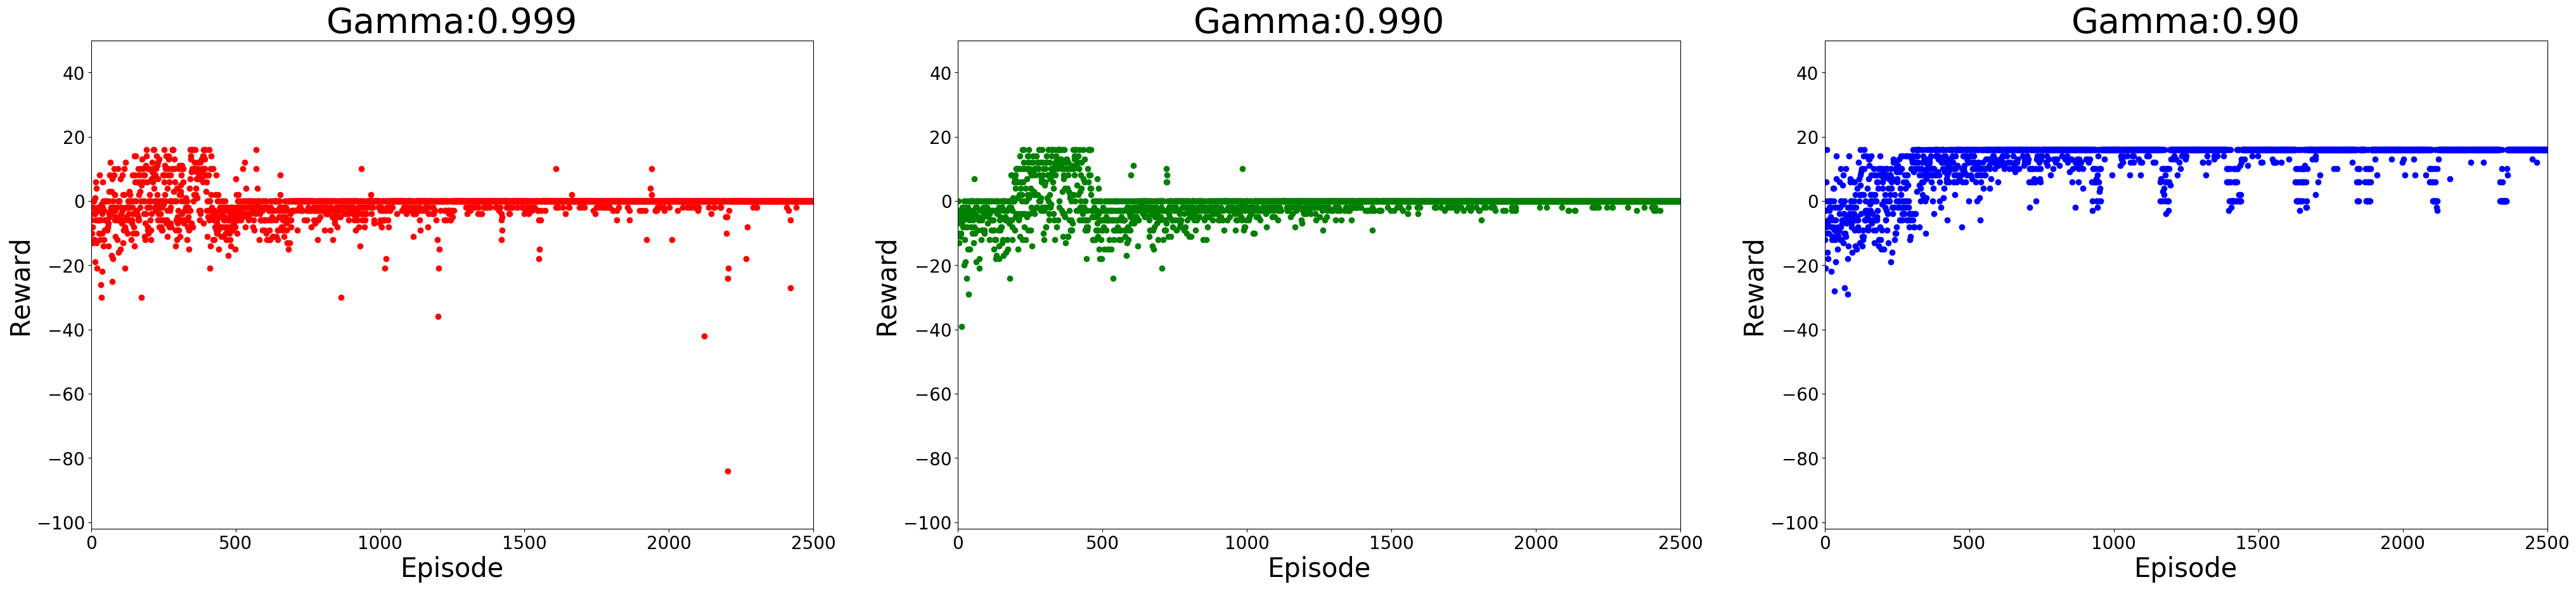

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_figheight(10)
fig.set_figwidth(50)
# fig.suptitle('Gamma Tuning', size="50")
ax1.plot(rewardSD_g1, 'ro')
ax1.set_title("Gamma:0.999", size=40)
ax1.set_ylabel('Reward', fontsize = 30) 
ax1.set_xlabel('Episode', fontsize = 30)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlim(100)
ax1.set_xlim(xmin=0, xmax=len(rewardSD_g1))
ax1.set_ylim(ymin=-102, ymax=50)
ax2.plot(rewardSD_g2, 'go')
ax2.set_title("Gamma:0.990", size=40)
ax2.set_ylabel('Reward', fontsize = 30) 
ax2.set_xlabel('Episode', fontsize = 30)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(xmin=0, xmax=len(rewardSD_g2))
ax2.set_ylim(ymin=-102, ymax=50)
ax3.plot(rewardSD_g3, 'bo')
ax3.set_title("Gamma:0.90", size=40)
ax3.set_ylabel('Reward', fontsize = 30) 
ax3.set_xlabel('Episode', fontsize = 30)
ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
ax3.set_xlim(xmin=0, xmax=len(rewardSD_g3))
ax3.set_ylim(ymin=-102, ymax=50)
plt.show()

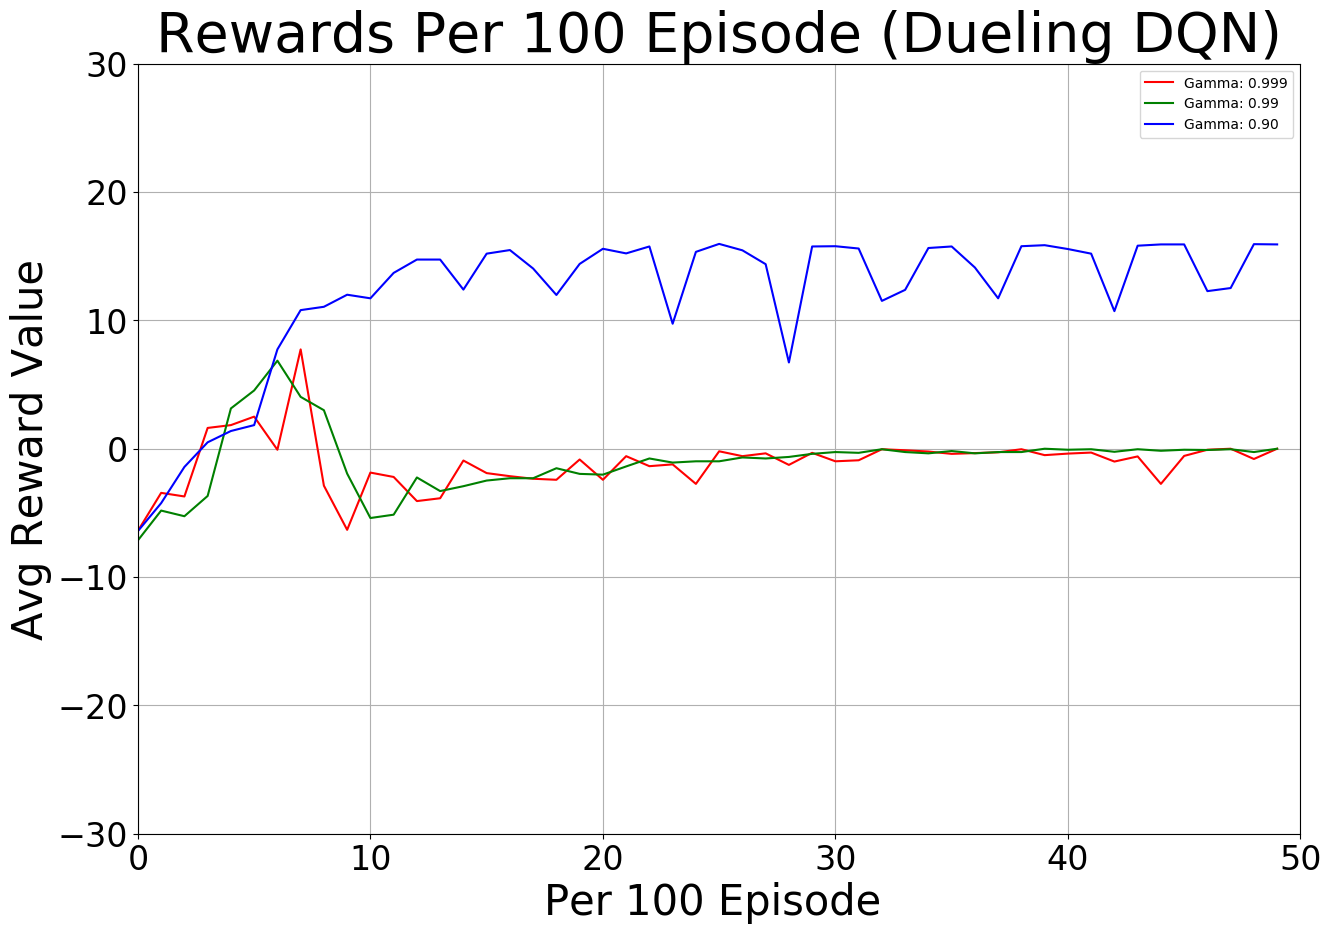

In [24]:
rewardQD_ts1_avg = []
rewardQD_ts2_avg = []
rewardQD_ts3_avg = []
for s in np.split(np.array(rewardSD_g1), 50):
    rewardQD_ts1_avg.append((sum(s)/len(s)))

for s in np.split(np.array(rewardSD_g2), 50):
    rewardQD_ts2_avg.append((sum(s)/len(s)))

for s in np.split(np.array(rewardSD_g3), 50):
    rewardQD_ts3_avg.append((sum(s)/len(s)))

plt.figure(figsize=(15, 10))
plt.plot(rewardQD_ts1_avg, 'r-')
plt.plot(rewardQD_ts2_avg, 'g-')
plt.plot(rewardQD_ts3_avg, 'b-')
plt.legend(["Gamma: 0.999", "Gamma: 0.99", "Gamma: 0.90"])
plt.xlabel('Per 100 Episode ', fontsize=30)
plt.ylabel('Avg Reward Value', fontsize=30)
plt.title('Rewards Per 100 Episode (Dueling DQN)', fontsize=40)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylim(ymin=-30, ymax=30)
plt.xlim(xmin=0, xmax=50)
plt.grid()
plt.show()

In [ ]:
env = MyMarioEnvironment2(environment_type = 'deterministic')
obs = env.reset()
a = GridDuelingDQN(env)
a.learn()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
  4%|▍         | 101/2500 [00:18<05:38,  7.09episodes/s]

Buffer_size: 2500|Train_time:0.004251000881195069| Sub_t:0.004661374092102051
[Episode: 100] - Steps: 29.69 | Rewards: -7.04 | Epsilon: 0.8317637711026726 | loss: 0.000


  8%|▊         | 202/2500 [00:32<04:20,  8.81episodes/s]

Buffer_size: 2500|Train_time:0.004064412117004395| Sub_t:0.004531457424163819
[Episode: 200] - Steps: 27.71 | Rewards: 0.02 | Epsilon: 0.691830970918939 | loss: 0.000


 12%|█▏        | 301/2500 [00:45<04:57,  7.38episodes/s]

Buffer_size: 2500|Train_time:0.003927607536315918| Sub_t:0.004474916458129883
[Episode: 300] - Steps: 26.32 | Rewards: 2.65 | Epsilon: 0.5754399373371608 | loss: 0.000


 16%|█▌        | 402/2500 [00:56<02:54, 12.05episodes/s]

Buffer_size: 2500|Train_time:0.004051899909973145| Sub_t:0.004632561206817627
[Episode: 400] - Steps: 20.35 | Rewards: 9.02 | Epsilon: 0.47863009232264275 | loss: 0.000


 20%|██        | 502/2500 [01:05<02:51, 11.68episodes/s]

Buffer_size: 2500|Train_time:0.004120700359344483| Sub_t:0.004803521633148193
[Episode: 500] - Steps: 18.66 | Rewards: 11.66 | Epsilon: 0.3981071705535017 | loss: 0.000


 24%|██▍       | 602/2500 [01:14<03:12,  9.86episodes/s]

Buffer_size: 2500|Train_time:0.00459050178527832| Sub_t:0.0052245140075683595
[Episode: 600] - Steps: 17.31 | Rewards: 12.61 | Epsilon: 0.3311311214825956 | loss: 0.000


 28%|██▊       | 701/2500 [01:23<02:07, 14.08episodes/s]

Buffer_size: 2500|Train_time:0.004133756160736084| Sub_t:0.004804103374481201
[Episode: 700] - Steps: 17.92 | Rewards: 13.04 | Epsilon: 0.27542287033382085 | loss: 0.000


 32%|███▏      | 802/2500 [01:29<01:48, 15.61episodes/s]

Buffer_size: 2500|Train_time:0.004280309677124023| Sub_t:0.004899060726165772
[Episode: 800] - Steps: 13.28 | Rewards: 14.73 | Epsilon: 0.22908676527678132 | loss: 0.000


 36%|███▌      | 903/2500 [01:37<02:05, 12.76episodes/s]

Buffer_size: 2500|Train_time:0.003957343101501465| Sub_t:0.004662649631500244
[Episode: 900] - Steps: 15.98 | Rewards: 14.09 | Epsilon: 0.19054607179632832 | loss: 0.000


 40%|████      | 1002/2500 [01:44<01:42, 14.56episodes/s]

Buffer_size: 2500|Train_time:0.004147412776947021| Sub_t:0.004790241718292236
[Episode: 1000] - Steps: 13.64 | Rewards: 15.0 | Epsilon: 0.15848931924611465 | loss: 0.000


 44%|████▍     | 1102/2500 [01:51<02:01, 11.51episodes/s]

Buffer_size: 2500|Train_time:0.0037442612648010253| Sub_t:0.004402105808258057
[Episode: 1100] - Steps: 14.49 | Rewards: 14.36 | Epsilon: 0.13182567385564378 | loss: 0.000


 48%|████▊     | 1202/2500 [01:58<01:28, 14.63episodes/s]

Buffer_size: 2500|Train_time:0.004809739589691162| Sub_t:0.0055637359619140625
[Episode: 1200] - Steps: 14.35 | Rewards: 15.28 | Epsilon: 0.10964781961432139 | loss: 0.000


 52%|█████▏    | 1302/2500 [02:05<01:28, 13.60episodes/s]

Buffer_size: 2500|Train_time:0.004024989604949951| Sub_t:0.0048108863830566406
[Episode: 1300] - Steps: 12.95 | Rewards: 14.88 | Epsilon: 0.09120108393559365 | loss: 0.000


 56%|█████▌    | 1403/2500 [02:11<01:04, 16.94episodes/s]

Buffer_size: 2500|Train_time:0.004080333709716797| Sub_t:0.0048531627655029295
[Episode: 1400] - Steps: 13.76 | Rewards: 14.06 | Epsilon: 0.07585775750292077 | loss: 0.000


 60%|██████    | 1502/2500 [02:18<00:52, 19.10episodes/s]

Buffer_size: 2500|Train_time:0.00414163589477539| Sub_t:0.004795284271240235
[Episode: 1500] - Steps: 11.92 | Rewards: 15.45 | Epsilon: 0.06309573444802141 | loss: 0.000


 64%|██████▍   | 1603/2500 [02:24<01:07, 13.34episodes/s]

Buffer_size: 2500|Train_time:0.004665999412536621| Sub_t:0.005342025756835938
[Episode: 1600] - Steps: 13.25 | Rewards: 14.8 | Epsilon: 0.052480746024979104 | loss: 0.000


 68%|██████▊   | 1703/2500 [02:32<00:58, 13.65episodes/s]

Buffer_size: 2500|Train_time:0.0038770103454589845| Sub_t:0.004568269252777099
[Episode: 1700] - Steps: 14.09 | Rewards: 13.75 | Epsilon: 0.043651583224018214 | loss: 0.000


 72%|███████▏  | 1801/2500 [02:37<00:43, 16.17episodes/s]

Buffer_size: 2500|Train_time:0.004007804393768311| Sub_t:0.004702129364013672
[Episode: 1800] - Steps: 10.71 | Rewards: 15.76 | Epsilon: 0.03630780547701154 | loss: 0.000


 76%|███████▌  | 1902/2500 [02:46<00:37, 15.76episodes/s]

Buffer_size: 2500|Train_time:0.004321665763854981| Sub_t:0.005147151947021485
[Episode: 1900] - Steps: 15.31 | Rewards: 13.41 | Epsilon: 0.030199517204021385 | loss: 0.000


 80%|████████  | 2001/2500 [02:54<00:34, 14.44episodes/s]

Buffer_size: 2500|Train_time:0.005927295684814453| Sub_t:0.00683354377746582
[Episode: 2000] - Steps: 12.4 | Rewards: 14.51 | Epsilon: 0.025118864315096866 | loss: 0.000


 84%|████████▍ | 2102/2500 [03:01<00:21, 18.69episodes/s]

Buffer_size: 2500|Train_time:0.004146881103515625| Sub_t:0.004912095069885254
[Episode: 2100] - Steps: 13.93 | Rewards: 14.21 | Epsilon: 0.02089296130854132 | loss: 0.000


 88%|████████▊ | 2203/2500 [03:08<00:17, 16.73episodes/s]

Buffer_size: 2500|Train_time:0.004433422088623047| Sub_t:0.005159649848937988
[Episode: 2200] - Steps: 12.09 | Rewards: 15.16 | Epsilon: 0.017378008287494567 | loss: 0.000


 92%|█████████▏| 2301/2500 [03:15<00:15, 12.45episodes/s]

Buffer_size: 2500|Train_time:0.003974878787994384| Sub_t:0.004626343250274658
[Episode: 2300] - Steps: 15.0 | Rewards: 13.95 | Epsilon: 0.014454397707459973 | loss: 0.000


 96%|█████████▌| 2400/2500 [03:24<00:06, 14.84episodes/s]

Buffer_size: 2500|Train_time:0.004387135505676269| Sub_t:0.0051581478118896485
[Episode: 2400] - Steps: 15.26 | Rewards: 12.28 | Epsilon: 0.012022644346174735 | loss: 0.000


100%|██████████| 2500/2500 [03:30<00:00, 11.88episodes/s]

Buffer_size: 2500|Train_time:0.003164935111999512| Sub_t:0.0037924528121948244
[Episode: 2500] - Steps: 10.73 | Rewards: 16.0 | Epsilon: 0.01000000000000053 | loss: 0.000


In [6]:
epsilon_list_train_dqn = a.epsilon_list
reward_list_train_dqn = a.rewards_list

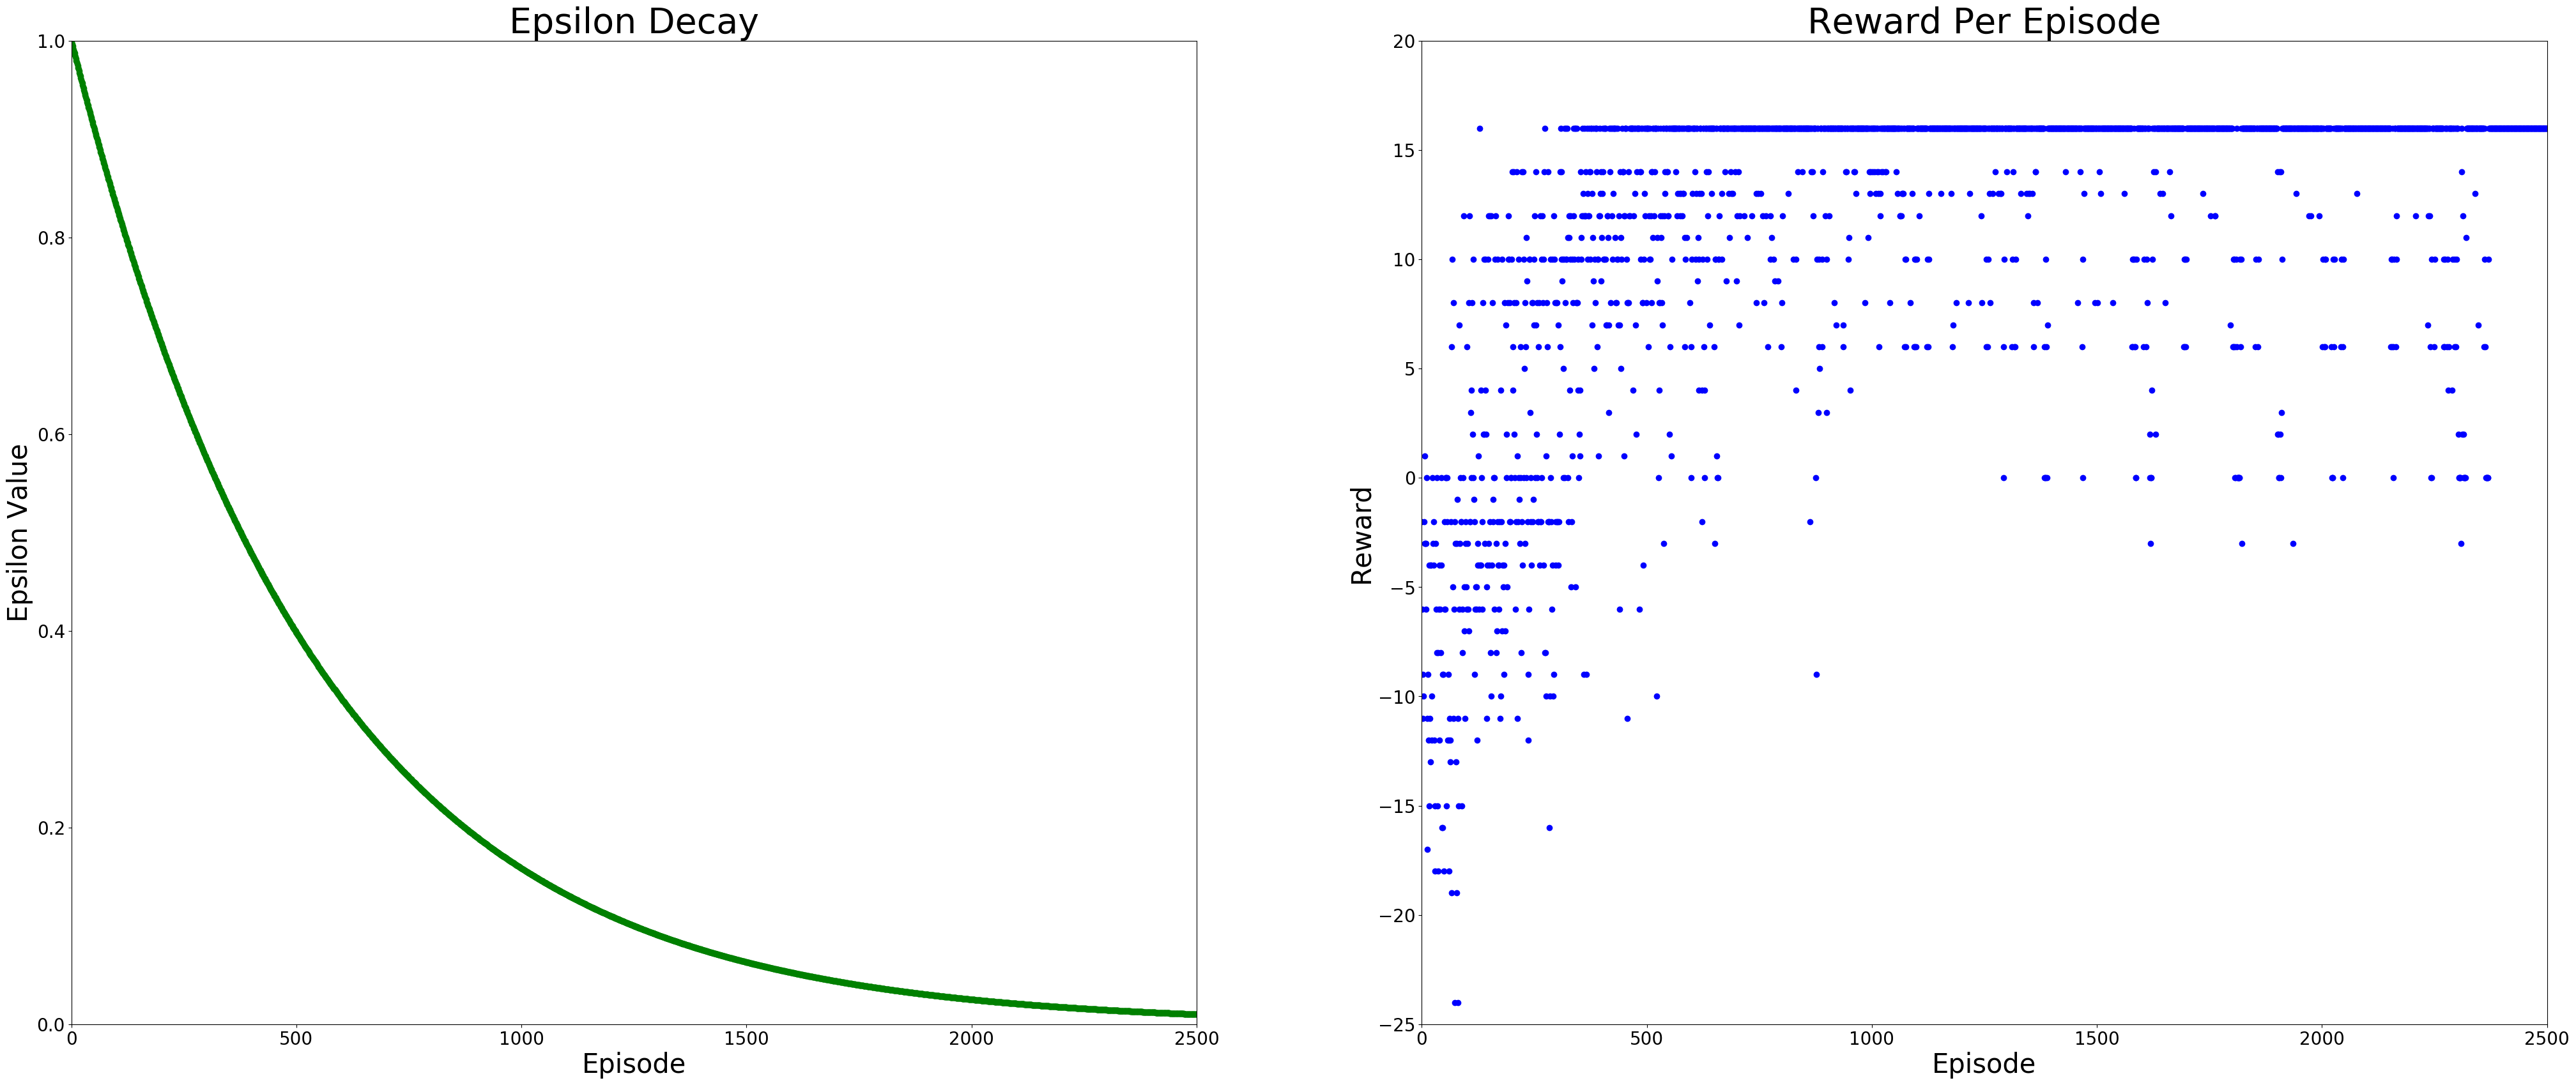

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(20)
fig.set_figwidth(50)
# fig.suptitle('Gamma Tuning', size="50")
ax1.plot(epsilon_list_train_dqn, 'go')
ax1.set_title("Epsilon Decay", size=40)
ax1.set_ylabel('Epsilon Value', fontsize = 30) 
ax1.set_xlabel('Episode', fontsize = 30)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.set_xlim(100)
ax1.set_xlim(xmin=0, xmax=a.max_episodes)
ax1.set_ylim(ymin=0, ymax=1)
ax2.plot(reward_list_train_dqn, 'bo')
ax2.set_title(f"Reward Per Episode", size=40)
ax2.set_ylabel('Reward', fontsize = 30) 
ax2.set_xlabel('Episode', fontsize = 30)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(xmin=0, xmax=a.max_episodes)
ax2.set_ylim(ymin=-25, ymax=20)
plt.show()

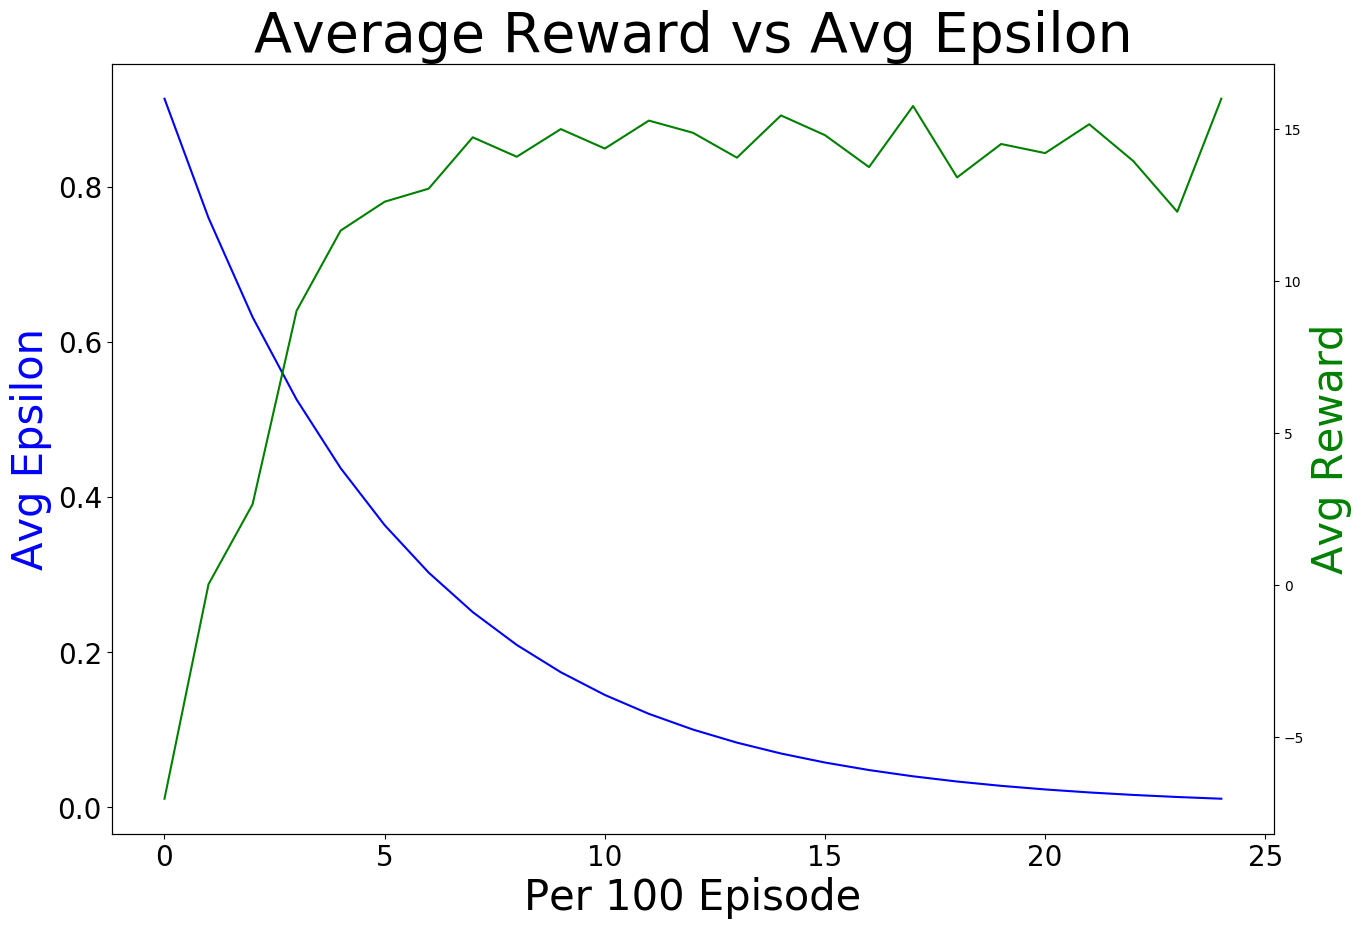

In [8]:
rewardSD_train_dqn_avg = []
for s in np.split(np.array(reward_list_train_dqn), 25):
    rewardSD_train_dqn_avg.append((sum(s)/len(s)))
    
epsilonSD_train_dqn_avg = []
for s in np.split(np.array(epsilon_list_train_dqn), 25):
    epsilonSD_train_dqn_avg.append((sum(s)/len(s)))

fig, ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
plt.tick_params(axis='both', which='major', labelsize=20)
ax2 = ax1.twinx()
ax1.plot(epsilonSD_train_dqn_avg, 'b-')
ax2.plot(rewardSD_train_dqn_avg, 'g-')
ax1.set_title("Average Reward vs Avg Epsilon", size=40)
ax1.set_xlabel('Per 100 Episode', fontsize=30)
ax1.set_ylabel('Avg Epsilon', color='b', fontsize=30)
ax2.set_ylabel('Avg Reward', color='g', fontsize=30)
plt.show()

In [12]:
import json
with open('reward_dueling.json', 'w') as f:
    json.dump(reward_list_train_dqn, f)

In [9]:
PATH = './grid.pth'
torch.save(a.q_value_dqn.state_dict(), PATH)

In [14]:
env = MyMarioEnvironment2(environment_type = 'deterministic')
env.reset()
a = GridDuelingDQN(env)
a.eval(load=True, max_ep=10)

100%|██████████| 10/10 [00:00<00:00, 69.04episodes/s]


In [15]:
reward_list_test_dqn = a.test_rewards_list

<Figure size 640x480 with 0 Axes>

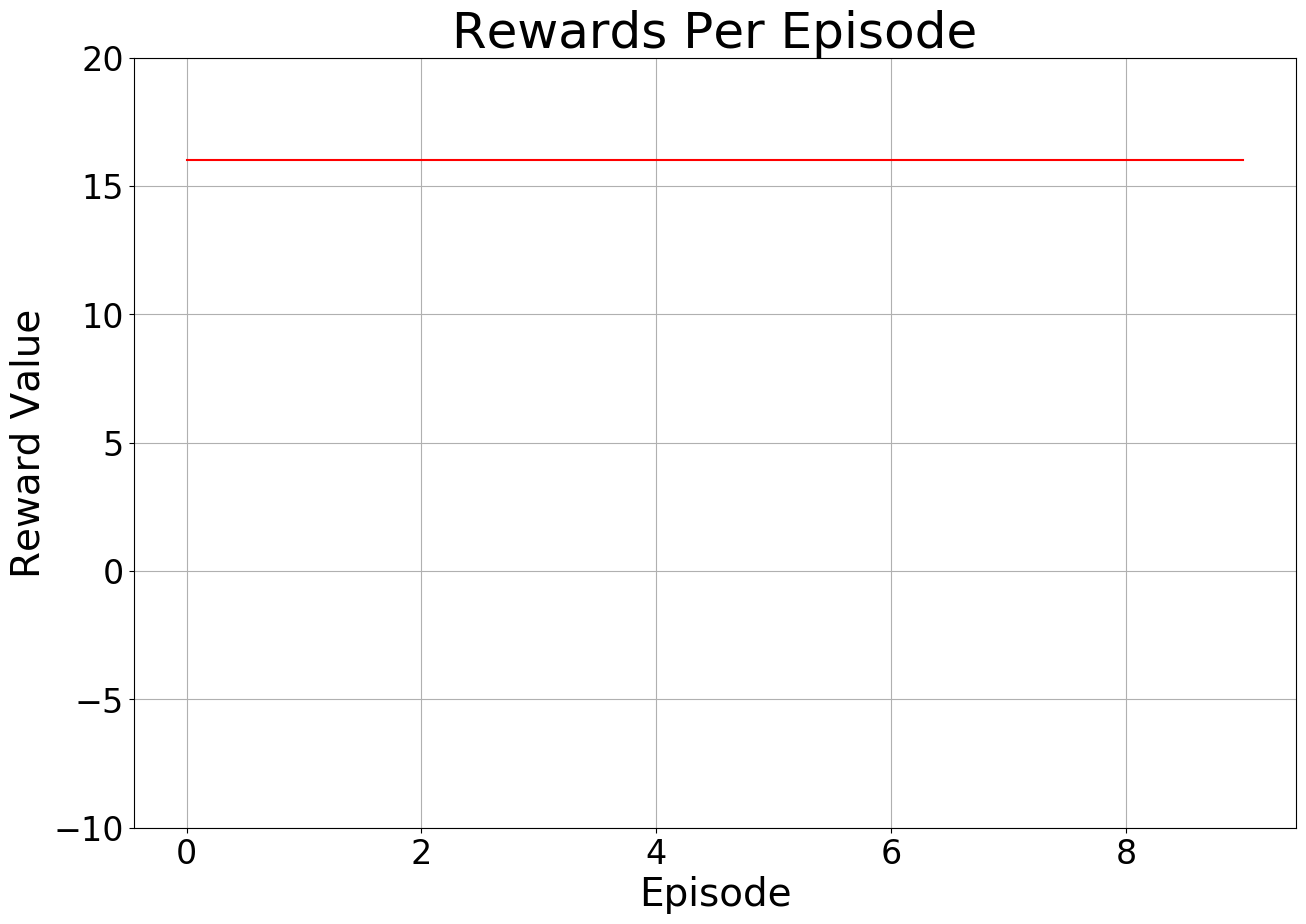

In [16]:
plt.clf()
plt.figure(figsize=(15, 10))
plt.plot(reward_list_test_dqn, 'r-')
plt.xlabel('Episode', fontsize=28)
plt.ylabel('Reward Value', fontsize=28)
plt.title(f'Rewards Per Episode', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# plt.yticks([-100, -50, 0, 10, 20], fontsize=24)
plt.ylim(ymin=-10, ymax=20)
# plt.xlim(xmin=0, xmax=self.max_episodes_test)
plt.grid()
plt.show()